**Imports**

In [1]:
# Third party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import seaborn as sns

# Goggle
from goggle.GoggleModel import GoggleModel

# Synthcity
from synthcity.plugins.core.dataloader import GenericDataLoader

/home/rob/miniconda3/envs/goggle10/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2023-03-07 14:40:04,212 - Created a temporary directory at /tmp/tmph1dtcuqj
2023-03-07 14:40:04,213 - Writing /tmp/tmph1dtcuqj/_remote_module_non_scriptable.py


**Load data**

In [2]:
dataset = "credit"
X = pd.read_csv("../data/german_credit_2.csv")
target = X.pop("Creditability")
X["target"] = target
X = X.dropna(axis=0)
ind = list(range(len(X.columns)))
ind = [x for x in ind if x != X.columns.get_loc("target")]
col_list = X.columns[ind]
ct = ColumnTransformer(
    [("scaler", StandardScaler(), col_list)], remainder="passthrough"
)

X_ = ct.fit_transform(X)
X = pd.DataFrame(X_, index=X.index, columns=X.columns)

X.head()
X.shape

(1000, 25)

**Fit model**

In [3]:
X_train, X_test = train_test_split(X, random_state=1, test_size=0.2, shuffle=True)

gen = GoggleModel(
    ds_name=dataset,
    input_dim=X_train.shape[1],
    encoder_dim=64,
    encoder_l=2,
    het_encoding=True,
    decoder_dim=64,
    decoder_l=2,
    threshold=0.1,
    decoder_arch="gcn",
    graph_prior=None,
    prior_mask=None,
    device="cpu",
    beta=0.1,
    learning_rate=0.01,
    seed=0,
)
gen.model

Goggle(
  (learned_graph): LearnedGraph(
    (act): Sigmoid()
    (threshold): Threshold(threshold=0.1, value=0)
  )
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=25, out_features=64, bias=True)
      (1): ReLU()
    )
    (encode_mu): Linear(in_features=64, out_features=25, bias=True)
    (encode_logvar): Linear(in_features=64, out_features=25, bias=True)
  )
  (graph_processor): GraphInputProcessorHomo()
  (decoder): GraphDecoderHomo(
    (decoder): Sequential(
      (0): GraphConv(
        in=64, out=32, normalization=both
        (_activation): Tanh()
      )
      (1): GraphConv(in=32, out=1, normalization=both, activation=None)
    )
  )
)

In [4]:
gen.fit(X_train)

[Epoch 100/1000, patience  0] train: 21.219, val: 21.771
[Epoch 200/1000, patience  5] train: 20.646, val: 21.212
[Epoch 300/1000, patience  0] train: 19.464, val: 20.197
[Epoch 400/1000, patience 46] train: 19.085, val: 19.948
Training terminated after 403 epochs


**Evaluate synthetic data**

In [5]:
X_synth = gen.sample(X_test)
X_synth.head()

,Attribute 1,Attribute 2,Attribute 3,Attribute 4,Attribute 5,Attribute 6,Attribute 7,Attribute 8,Attribute 9,Attribute 10,...,Attribute 16,Attribute 17,Attribute 18,Attribute 19,Attribute 20,Attribute 21,Attribute 22,Attribute 23,Attribute 24,target
0,-1.254566,-0.621255,-1.427149,-0.741726,-0.699707,-1.145978,-0.963650,0.140505,-0.341055,-1.148854,...,-0.552705,-0.338862,0.320212,-0.206768,-0.466933,-1.576173,-0.149983,-0.5,-1.304877,1.0
1,0.336513,0.088999,0.420293,0.078540,0.566731,0.510060,0.449326,0.140505,-0.341055,0.319186,...,-0.552705,-0.338862,0.320212,-0.206768,-0.466933,0.634448,-0.149983,-0.5,0.766356,1.0
2,-0.459026,0.064214,-0.503428,0.040935,-0.066488,-0.317959,0.449326,1.046987,0.611613,-0.061394,...,-0.552705,-0.338862,0.320212,-0.206768,2.141633,-1.576173,-0.149983,-0.5,0.766356,2.0
3,0.336513,0.885998,1.344014,0.939702,1.199950,1.338078,0.449326,1.046987,0.611613,0.968292,...,-0.552705,-0.338862,0.320212,-0.206768,-0.466933,0.634448,-0.149983,-0.5,0.766356,2.0
4,-1.254566,-0.776859,-1.427149,-0.912762,-0.699707,-1.145978,-0.963650,0.140505,-0.341055,-1.373823,...,-0.552705,-0.338862,0.320212,-0.206768,-0.466933,-1.576173,-0.149983,-0.5,-1.304877,1.0


In [6]:
X_synth_loader = GenericDataLoader(
    X_synth,
    target_column="target",
)
X_test_loader = GenericDataLoader(
    X_test,
    target_column="target",
)

res = gen.evaluate_synthetic(X_synth_loader, X_test_loader)
print(f"Quality: {res[0]:.3f}")
print(f"Detection: {res[2]:.3f}")
print(
    f"Performance on real: {res[1][0]:.3f}, on synth: {res[1][1]:.3f}, diff: {(res[1][0] - res[1][1]):.3f}"
)

Quality: 0.457
Detection: 0.806
Performance on real: 0.663, on synth: 0.559, diff: 0.105


**Generate TSNE plots**

In [7]:
X_test["label"] = "Original"
X_synth["label"] = "Synthetic"

concat_df = pd.concat([X_test, X_synth], axis=0)
y_data = concat_df["label"]
x_data = concat_df.drop(["label", "target"], axis=1)

In [8]:
tsne = TSNE(n_components=2, verbose=0, random_state=0)
z = tsne.fit_transform(x_data)
df = pd.DataFrame()
df["y"] = y_data
df["comp-1"] = z[:, 0]
df["comp-2"] = z[:, 1]

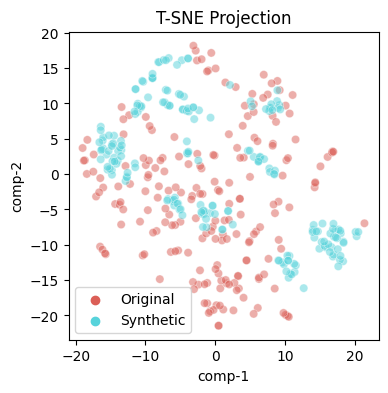

In [9]:
plt.figure(figsize=(4, 4))
sns.scatterplot(
    x="comp-1",
    y="comp-2",
    hue=df.y.tolist(),
    palette=sns.color_palette("hls", 2),
    alpha=0.5,
    data=df,
).set(title=f"T-SNE Projection")
plt.xlabel("comp-1")
plt.ylabel("comp-2")
plt.legend()

plt.show()

**Visualise adjacency matrix**

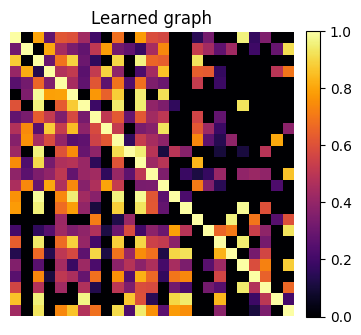

In [10]:
adj_matrix = gen.model.learned_graph(100).cpu().detach().numpy()
plt.figure(figsize=(4, 4))
im = plt.imshow(adj_matrix, cmap="inferno", interpolation="nearest", vmin=0, vmax=1.0)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title("Learned graph")
plt.axis("off")
plt.show()